# Form Recognition in Spark Ocr

End-to-end form recognition using VisualDocumentNerV2 and FormRelationExtractor.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-ocr-workshop/blob/master/tutorials/Certification_Trainings/3.2.SparkOcrFormRecognition.ipynb)

## Blogposts and videos

- [Text Detection in Spark OCR](https://medium.com/spark-nlp/text-detection-in-spark-ocr-dcd8002bdc97)

- [Table Detection & Extraction in Spark OCR](https://medium.com/spark-nlp/table-detection-extraction-in-spark-ocr-50765c6cedc9)

- [Extract Tabular Data from PDF in Spark OCR](https://medium.com/spark-nlp/extract-tabular-data-from-pdf-in-spark-ocr-b02136bc0fcb)

- [Signature Detection in Spark OCR](https://medium.com/spark-nlp/signature-detection-in-spark-ocr-32f9e6f91e3c)

- [GPU image pre-processing in Spark OCR](https://medium.com/spark-nlp/gpu-image-pre-processing-in-spark-ocr-3-1-0-6fc27560a9bb)

- [How to Setup Spark OCR on UBUNTU - Video](https://www.youtube.com/watch?v=cmt4WIcL0nI)


**More examples here**

https://github.com/JohnSnowLabs/spark-ocr-workshop

### Colab Setup

In [ ]:
import json, os
import sys

if 'google.colab' in sys.modules:
    from google.colab import files

    if 'spark_ocr.json' not in os.listdir():
      license_keys = files.upload()
      os.rename(list(license_keys.keys())[0], 'spark_ocr.json')

with open('spark_ocr.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [ ]:
# Installing pyspark and spark-nlp
%pip install --upgrade -q pyspark==3.2.1 spark-nlp==$PUBLIC_VERSION

# Installing Spark OCR
#! pip uninstall spark-ocr -Y
%pip install spark-ocr==$OCR_VERSION --extra-index-url=https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET --upgrade

<b><h1><font color='darkred'>!!! ATTENTION !!! </font><h1><b>

<b>After running previous cell, <font color='darkred'>RESTART the COLAB RUNTIME </font> and go ahead.<b>

In [1]:
import json, os

with open("spark_ocr_5.json", 'r') as f:
  license_keys = json.load(f)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [2]:
from pyspark.ml import PipelineModel
import pyspark.sql.functions as f

In [3]:
import pkg_resources

from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

from sparkocr import start
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import *
from sparkocr.metrics import score

## Start spark session

In [4]:
# Start spark
spark = start(secret=SPARK_OCR_SECRET, nlp_version=PUBLIC_VERSION)

Spark version: 3.2.1
Spark NLP version: 4.4.4
Spark NLP for Healthcare version: 4.4.2
Spark OCR version: 5.0.0rc1



## Load image


    Image #0:
    Origin: file:/home/jose/.local/lib/python3.7/site-packages/sparkocr/resources/ocr/forms/form1.jpg
    Resolution: 150 dpi
    Width: 1240 px
    Height: 1755 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


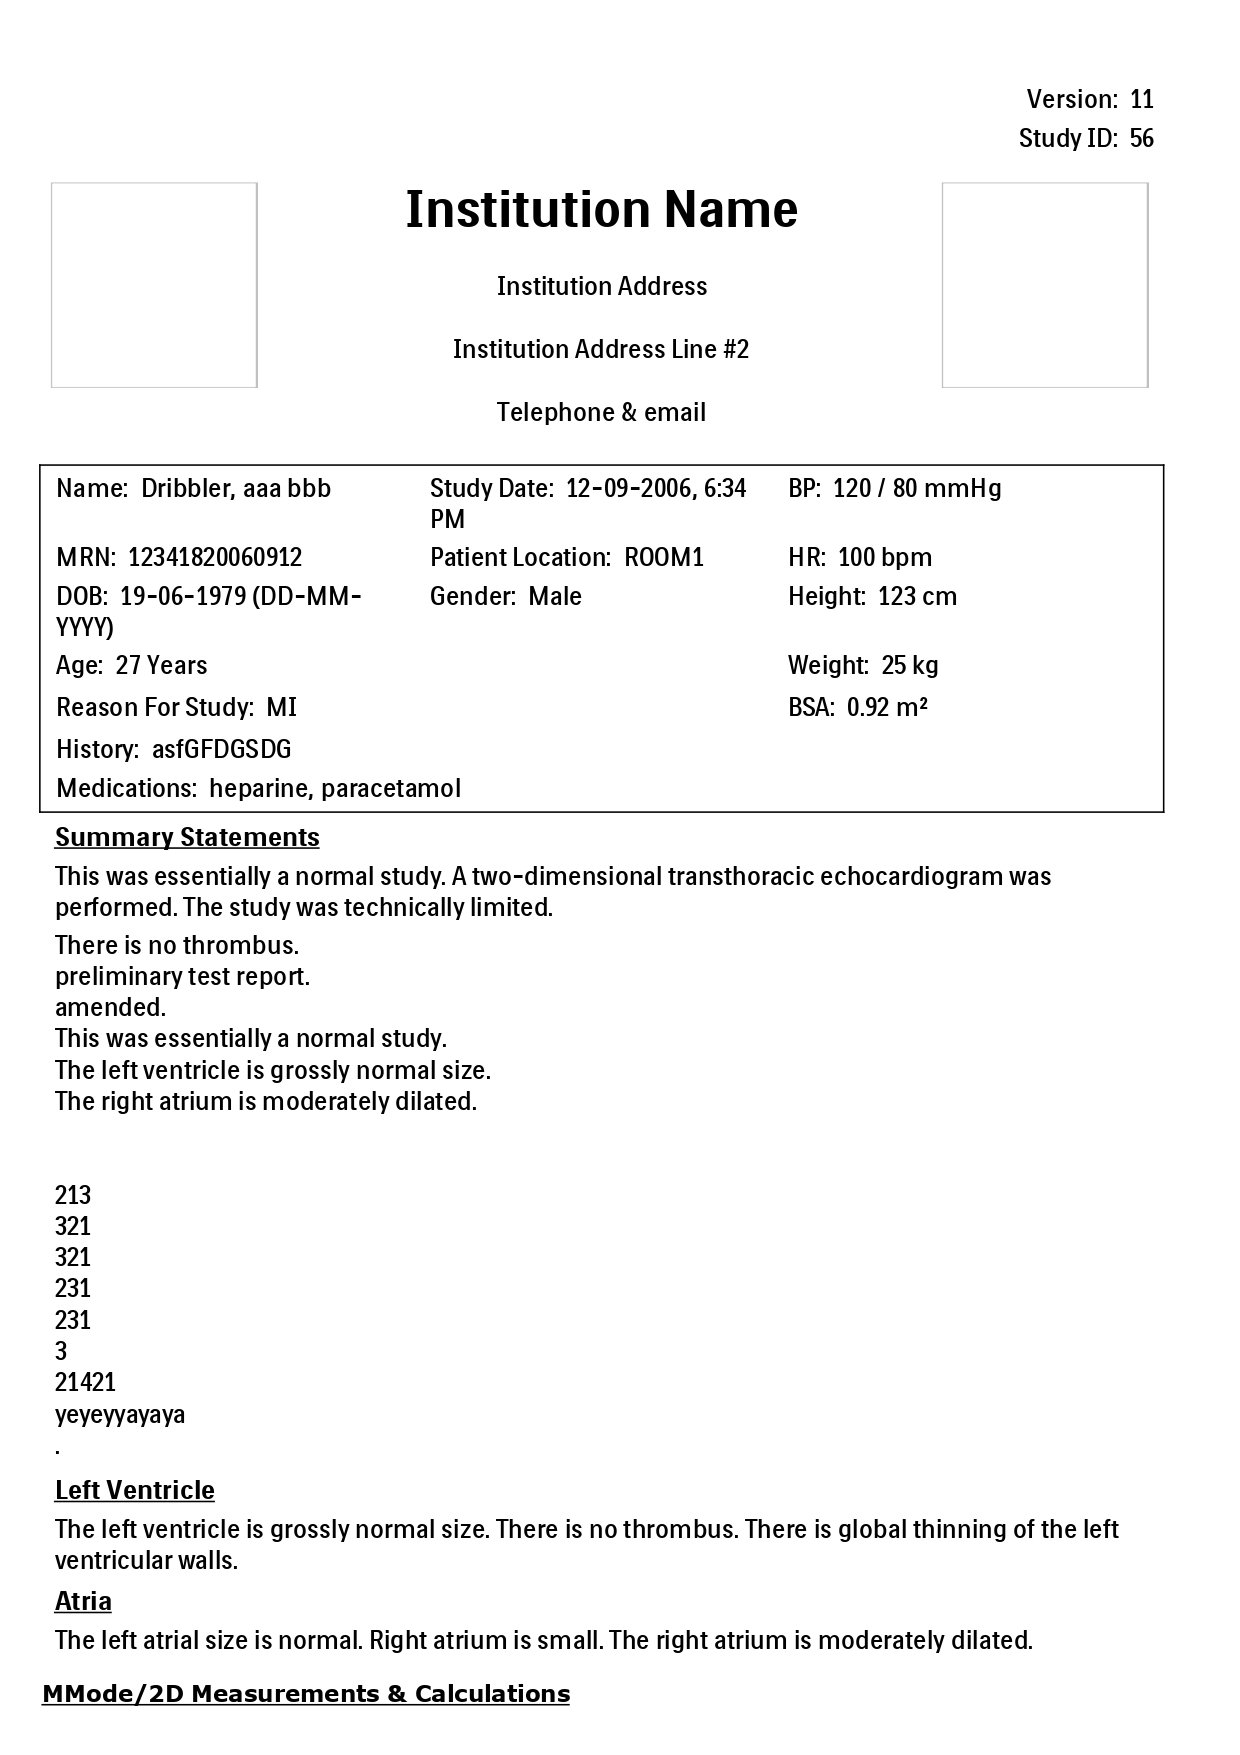

In [5]:
import pkg_resources
test_image_path = pkg_resources.resource_filename('sparkocr', 'resources/ocr/forms/form1.jpg')
bin_df = spark.read.format("binaryFile").load(test_image_path)
display_images(BinaryToImage().transform(bin_df))

## Define pipeline

In [6]:
binary_to_image = BinaryToImage()\
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

img_to_hocr = ImageToHocr()\
    .setInputCol("image")\
    .setOutputCol("hocr")\
    .setIgnoreResolution(False)\
    .setOcrParams(["preserve_interword_spaces=0"])

tokenizer = HocrTokenizer()\
    .setInputCol("hocr")\
    .setOutputCol("tokens")

doc_ner = VisualDocumentNer()\
    .pretrained("lilt_roberta_funsd_v1", "en", "clinical/ocr")\
    .setInputCols(["tokens", "image"])\
    .setOutputCol("entities")

rel_extractor = FormRelationExtractor() \
    .setInputCol("entities") \
    .setOutputCol("relations")

draw_key_values = ImageDrawAnnotations() \
    .setInputCol("image") \
    .setInputChunksCol("relations") \
    .setOutputCol("image_with_annotations") \
    .setFontSize(10) \
    .setLineWidth(4)\
    .setRectColor(Color.red)

draw_ner = ImageDrawAnnotations() \
    .setInputCol("image") \
    .setInputChunksCol("entities") \
    .setOutputCol("image_with_ner") \
    .setFontSize(10) \
    .setLineWidth(4)\
    .setRectColor(Color.red)

# OCR pipeline
pipeline = PipelineModel(stages=[
    binary_to_image,
    img_to_hocr,
    tokenizer,
    doc_ner,
    rel_extractor,
    draw_key_values,
    draw_ner
])

lilt_roberta_funsd_v1 download started this may take some time.
Approximate size to download 419.6 MB


## Call pipeline

In [7]:
results = pipeline.transform(bin_df).cache()
results.select(f.explode("entities")).show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------+
|col                                                                                                                                                    |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
|{named_entity, 0, 7, b-question, {x -> 1027, y -> 89, height -> 19, confidence -> 106, token -> version, ocr_confidence -> 96, width -> 90}, []}       |
|{named_entity, 7, 8, i-question, {x -> 1027, y -> 89, height -> 19, confidence -> 67, token -> :, ocr_confidence -> 96, width -> 90}, []}              |
|{named_entity, 10, 15, b-question, {x -> 1020, y -> 128, height -> 23, confidence -> 95, token -> study, ocr_confidence -> 96, width -> 61}, []}       |
|{named_entity, 15, 17, b-question, {x -> 1088, y -> 128, height -> 19, conf

## Show results

In [8]:
results.select("exception").show(truncate=False)

+---------+
|exception|
+---------+
|null     |
+---------+



In [9]:
results.select(f.explode("relations.result")).show(20, False)

+--------------------------------------------+
|col                                         |
+--------------------------------------------+
|name : dribbler , bbb                       |
|study date : 12 - 09 - 2006 , 6 : 34        |
|bp : 120 / 80 mmhg                          |
|mrn : 12341820060912                        |
|patient location : room                     |
|hr : 100 bpm                                |
|dob : 19 - 06 - 1979                        |
|gender : male                               |
|height : 123 cm                             |
|age : 27 years                              |
|weight : 25 kg                              |
|reason for study : mi                       |
|bsa : 0 . 92 m                              |
|history : asfgfdgsdg                        |
|medications : heparine , paracetamol        |
|performed .: the study technically limited .|
|.: no                                       |
+--------------------------------------------+



In [10]:
results.withColumn("metadata", f.explode("relations.metadata")) \
 .select(f.col("metadata.entity1").alias("key"), f.col("metadata.entity2").alias("value")).show(20, False)

+------------------+-------------------------------+
|key               |value                          |
+------------------+-------------------------------+
|name :            |dribbler , bbb                 |
|study date :      |12 - 09 - 2006 , 6 : 34        |
|bp :              |120 / 80 mmhg                  |
|mrn :             |12341820060912                 |
|patient location :|room                           |
|hr :              |100 bpm                        |
|dob :             |19 - 06 - 1979                 |
|gender :          |male                           |
|height :          |123 cm                         |
|age :             |27 years                       |
|weight :          |25 kg                          |
|reason for study :|mi                             |
|bsa :             |0 . 92 m                       |
|history :         |asfgfdgsdg                     |
|medications :     |heparine , paracetamol         |
|performed .       |the study technically limi

### Show NER results


    Image #0:
    Origin: file:/home/jose/.local/lib/python3.7/site-packages/sparkocr/resources/ocr/forms/form1.jpg
    Resolution: 0 dpi
    Width: 1240 px
    Height: 1755 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


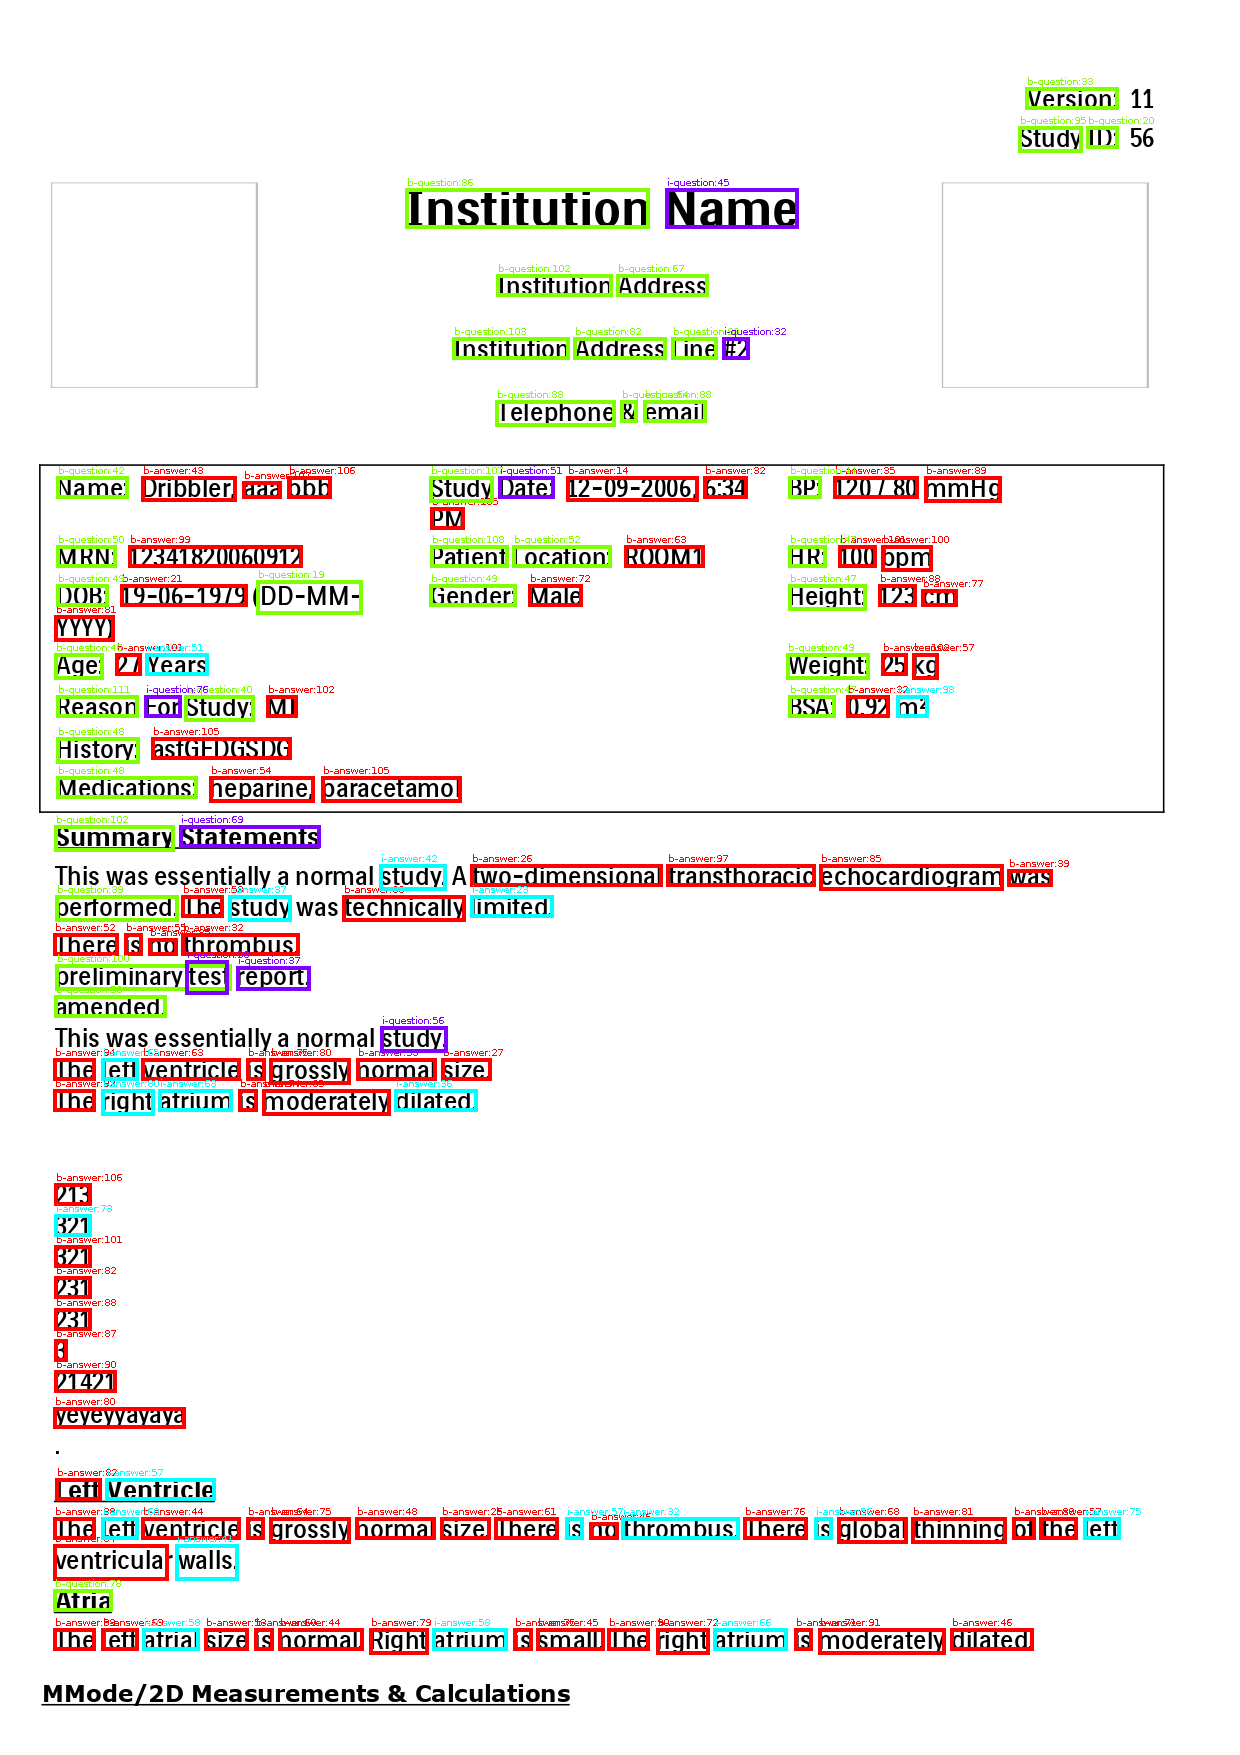

In [11]:
display_images(results, "image_with_ner")

### Show final annotations


    Image #0:
    Origin: file:/home/jose/.local/lib/python3.7/site-packages/sparkocr/resources/ocr/forms/form1.jpg
    Resolution: 0 dpi
    Width: 1240 px
    Height: 1755 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


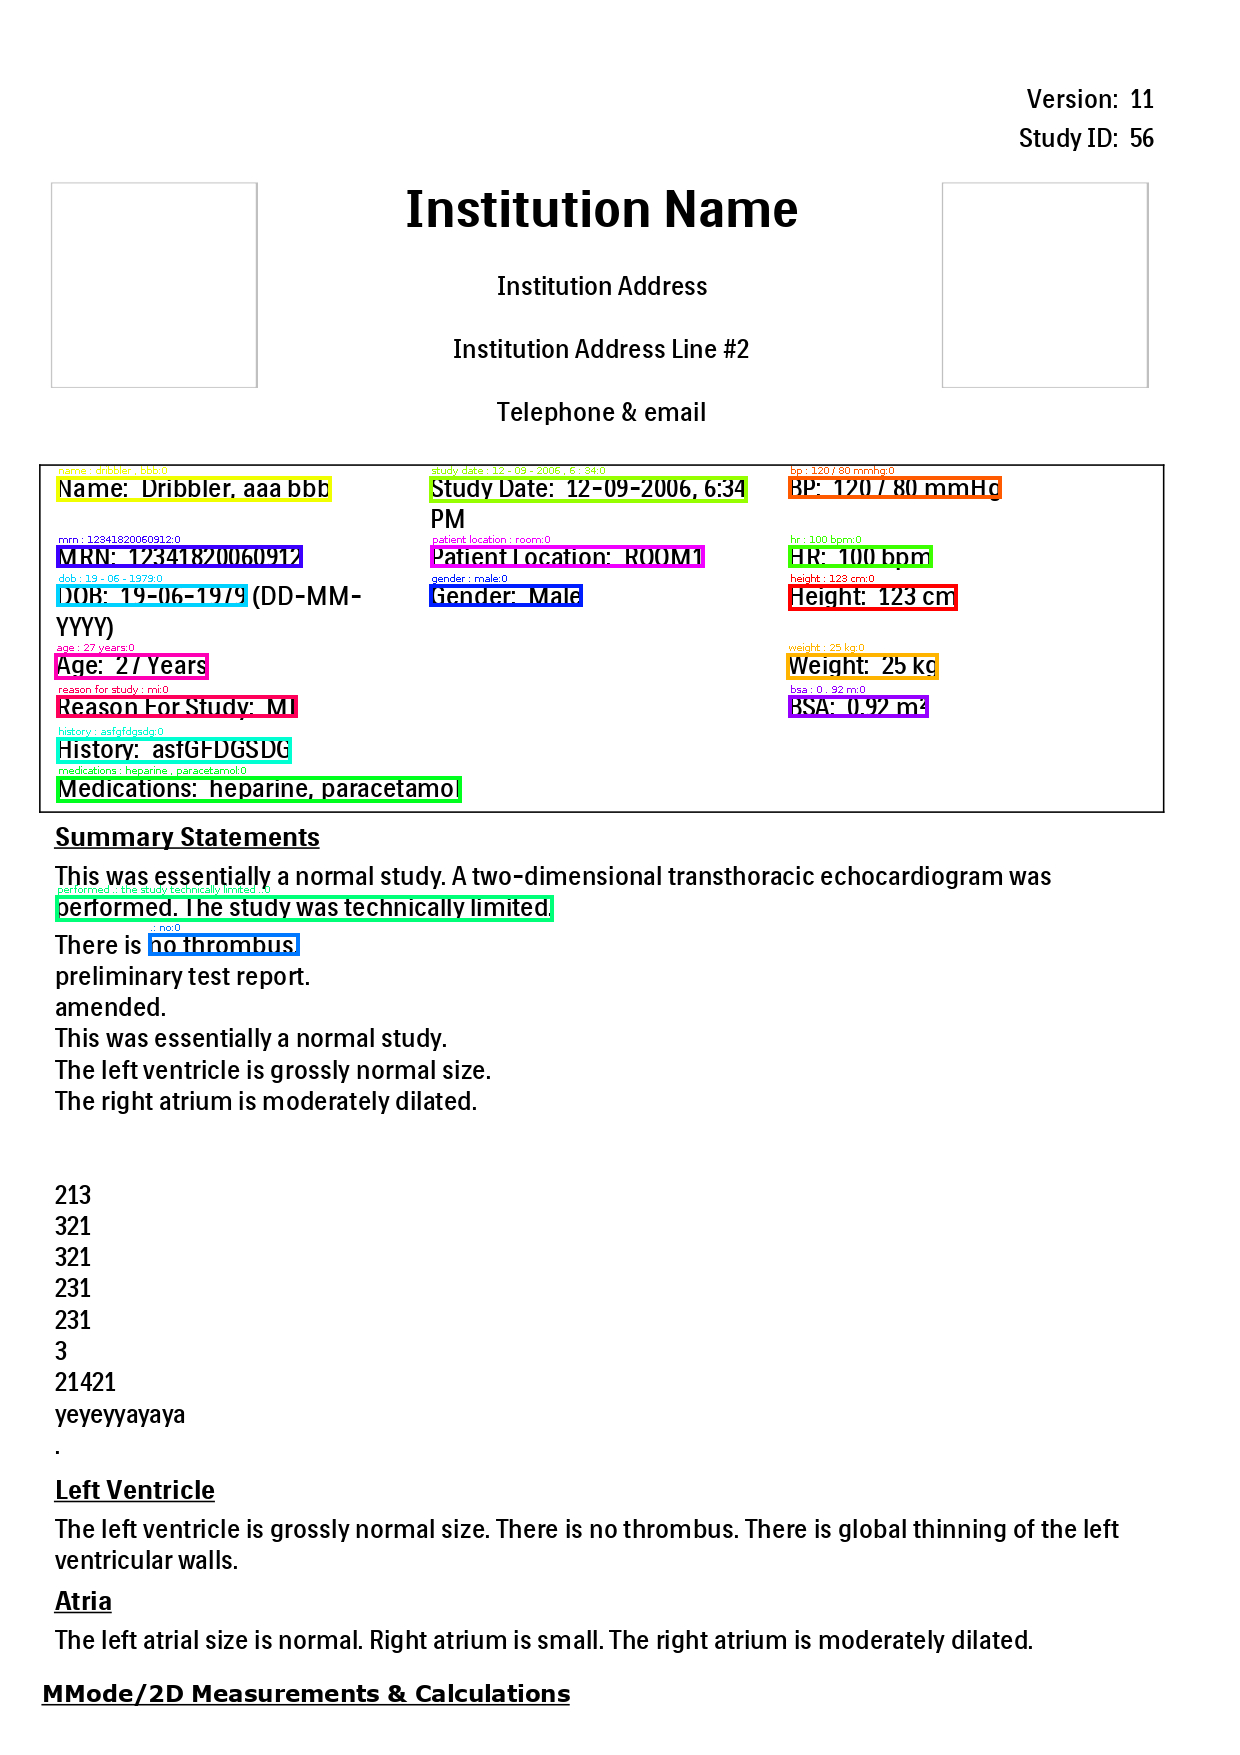

In [13]:
display_images(results, "image_with_annotations")